# Lesson 2 project 1: Game of Life

In [1]:
import numpy as np
import matplotlib.pyplot as plt

<br><br><br>

## Introduction

In this exercise, you will implement [Conway's Game of Life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life) in an array-oriented way.

You've probably seen this before: it's a cellular automata in which a boolean grid of "living" and "dead" cells (microbes) are updated in discrete time-steps. In a time-step, each cell is affected by its 8 neighbors.

<center>
<img src="../img/Moore_neighborhood_with_cardinal_directions.svg" width="300px">
</center>

  1. Any live cell with fewer than 2 live neighbours dies, as if by underpopulation.
  2. Any live cell with 2 or 3 live neighbours lives on to the next generation.
  3. Any live cell with more than 3 live neighbours dies, as if by overpopulation.
  4. Any dead cell with exactly 3 live neighbours becomes a live cell, as if by reproduction.

Incidentally, in APL

```apl
life ← {↑1　⍵∨.∧3　4=+/,¯1　0　1∘.⊖¯1　0　1∘.⌽⊂⍵}
```

To see that it is working, we'll set the initial state of the board like this:

In [7]:
WIDTH = 128
HEIGHT = 32

def new_world():
    world = np.zeros((HEIGHT, WIDTH), dtype=np.int32)

    for x, y in [
        ( 4, 125), ( 3, 124), ( 3, 123), ( 3, 122), ( 3, 121), ( 3, 120), ( 3, 119), ( 4, 119), ( 5, 119), ( 6, 120),
        (10, 121), (11, 120), (12, 119), (12, 120), (13, 120), (13, 121), (14, 121),
        (20, 121), (19, 120), (18, 120), (18, 119), (17, 121), (17, 120), (16, 121),
        (26, 125), (27, 124), (27, 123), (27, 122), (27, 121), (27, 120), (27, 119), (26, 119), (25, 119), (24, 120)
    ]:
        world[x][y] = 1

    return world

#world = new_world()

(This initial state is called a "puffer," and [it came from here](http://www.ericweisstein.com/encyclopedias/life/Puffer.html).)

When the game runs, it will look like this:

<center>
<img src="../img/game-of-life-puffer.gif" width="594px">
</center>

<br><br><br>

## Visualizing the world

During development, you'll need a way to see what you're doing, so you'll need a quick way to get the grid of booleans onto the screen. You could use Matplotlib's `imshow`,

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

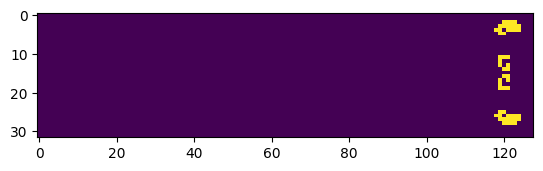

In [9]:
plt.imshow(world);
print(world)

but I would use ASCII art for something like this, so that it's easier to count cells and understand when something's going wrong. Make sure your window is wide enough that you see this as a box.

You might find other characters to be more useful than `@` and `.`, such as `*` and ` `.

In [10]:
def show(world):
    for row in world:
        print("|" + "".join("@" if cell else "." for cell in row) + "|")

show(world)

|................................................................................................................................|
|................................................................................................................................|
|........................................................................................................................@@@@....|
|.......................................................................................................................@@@@@@...|
|......................................................................................................................@@.@@@@...|
|.......................................................................................................................@@.......|
|................................................................................................................................|
|..................................................................................

<br><br><br>

## Imperative implementation

Following the rules set out above, a straightforward implementation with Python `for` loops would be:

In [11]:
def step_python(world):
    outworld = []
    for i, row in enumerate(world):
        outrow = []
        for j, cell in enumerate(row):
            # count the number of living neighbors
            num_neighbors = 0
            for di in -1, 0, 1:
                for dj in -1, 0, 1:
                    if (di, dj) != (0, 0):
                        if world[(i + di) % HEIGHT][(j + dj) % WIDTH]:
                            num_neighbors += 1

            # use that information to decide if the next value of this cell is 0 or 1
            if cell and 1 < num_neighbors < 4:
                outrow.append(1)
            elif not cell and num_neighbors == 3:
                outrow.append(1)
            else:
                outrow.append(0)

        outworld.append(outrow)
    return outworld

Note that this implementation creates a new world and returns it as output, rather than modifying the original world. That's a good practice, since the "number of neighbors" in the rules refers to the number in the current time-step, not a state that is partly the current time-step and partly the next time-step.

(If you really want your implementation to avoid creating new arrays in each time-step, you could make two arrays: one for the current, the other for the next time-step, then alternate between them.)

This implementation used

```python
(i + di) % HEIGHT
```

and

```python
(j + dj) % WIDTH
```

to make the "left neighbor" of the left edge be the right edge and the "top neighbor" of the top edge be the bottom edge, like this:

<center>
<img src="../img/Torus_graph.png" width="300px">
</center>

but the problem was set up in such a way that you don't need to worry about edge conditions whose value is 0 ("dead"). If implemented properly, none of the edges will be 1 ("alive") until iteration 237. You can run it for 236 iterations and not worry about the edges.

To see this function in action, repeatedly evaluate the next Jupyter cell (control-enter).

In [12]:
# world = new_world()       # uncomment to reset the world

world = step_python(world)
show(world)

|................................................................................................................................|
|.........................................................................................................................@@.....|
|.......................................................................................................................@....@...|
|......................................................................................................................@.........|
|......................................................................................................................@.....@...|
|......................................................................................................................@@@@@@....|
|................................................................................................................................|
|..................................................................................

<br><br><br>

## The exercise

Implement the same algorithm using [array-oriented NumPy routines](https://numpy.org/doc/stable/reference/index.html).

Maybe just slices and assignment: you don't need special functions (though you can use them).

(If you think you're really clever, try solving it with [scipy.signal.convolve2d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html)!)

**Criteria:**

By "array-oriented," I mean that each Python function call performs an operation on the whole grid, not one cell of the grid. There should be no Python `for` loops iterating over the cells, whether

   * explicitly as a `for` statement
   * explicitly in a list comprehension
   * implicitly in functions like `map`, `filter`, and `sum`, or anything from `itertools`.

One (rough) way to tell if you're following these rules is if the performance is on a NumPy scale, rather than a Python scale.

For instance,

In [ ]:
%%timeit

step_python(world)

but a

```python
%%timeit

step_numpy(world)
```

would be about an order of magnitude faster, at least.

In [ ]:
def step_numpy(world):
    ...

<br><br><br>

**Self-check:** does your `step_numpy` always return the same results as `step_python`?

```python
assert np.array_equal(step_numpy(world), step_python(world))
```

<br><br><br>

<details>
    <summary><b>Hint!</b></summary>

Can you make a 2D array of the number of live neighbors each cell has?

If so, the Game of Life rules are

```python
survivors = ((world == 1) & (num_neighbors > 1) & (num_neighbors < 4))  # old cells that survive
births    = ((world == 0) & (num_neighbors == 3))                       # new cells that are born
new_world = (births | survivors)
```

<br>

In fact, make `count_neighbors(world)` a separate function from `step_numpy(world)`, so that you can debug it with

```python
def show_neighbors(num_neighbors):
    for row in num_neighbors:
        print("|" + "".join(str(cell) if cell else " " for cell in row) + "|")
```

</details>

<details>
    <summary><b>Second hint!</b></summary>

Given a one-dimensional array

| | index 0 | index 1 | index 2 | index 3 | index 4 | index 5 | index 6 |
|:-|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
| **array values** | 0 | 0 | 1 | 0 | 1 | 0 | 0 |

How would you calculate these live left-neighbors and these live right-neighbors, then add them up to the total number of live neighbors?

| | index 0 | index 1 | index 2 | index 3 | index 4 | index 5 | index 6 |
|:-|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
| **left neighbors** | 0 | 0 | 0 | 1 | 0 | 1 | 0 |
| **right neighbors** | 0 | 1 | 0 | 1 | 0 | 0 | 0 |
| **total neighbors** | 0 | 1 | 0 | 2 | 0 | 1 | 0 |

</details>